In [1]:
import numpy as np
import pandas as pd
import copy
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader


In [2]:
import json
import os
from os.path import join as path_join


def load_data(path):
    tasks = pd.Series()
    for file_path in os.listdir(path):
        task_file = path_join(path, file_path)

        with open(task_file, 'r') as f:
            task = json.load(f)

        tasks[file_path[:-5]] = task
    return tasks

In [3]:
train_tasks = load_data('abstraction-and-reasoning-challenge/training/')
evaluation_tasks = load_data('abstraction-and-reasoning-challenge/evaluation/')
test_tasks = load_data('abstraction-and-reasoning-challenge/test/')

In [4]:
import torch.nn as nn
import torch 
from torch.nn import CrossEntropyLoss, MSELoss
from torch.optim import Adam
from torch.nn import Conv2d
from torch import FloatTensor, LongTensor
import torch.nn.functional as F

device = 'cuda' if torch.cuda.is_available() else 'cpu'

def increase_dim(matrix):
    matrix = np.array(matrix)
    matrix_out = np.full((10, matrix.shape[0], matrix.shape[1]), 0, dtype=np.uint8)
    for i in range(10):
        matrix_out[i] = (matrix==i)
    return matrix_out

def decrease_dim(matrix):
    return matrix.squeeze(0).argmax(0).cpu().numpy()


class CellularAutomata(nn.Module):     
    
    def __init__(self, num_states=10, num_hidden_layers=1):
        
        super(CellularAutomata, self).__init__()
        
        # sequential network
        net = nn.Sequential()
        
        # same number of channels as paper which network is based off of (100)
        net.add_module(
            "conv_in", nn.Conv2d(in_channels=num_states, out_channels=100, kernel_size=3, padding=1)
        )
        
        # ReLu activation
        net.add_module("relu_in", nn.ReLU())
        
        # adding number of hidden layers
        for i in range(0, num_hidden_layers):
            net.add_module(
                "conv_h" + str(i), nn.Conv2d(in_channels=100, out_channels=100, kernel_size=1),
            )             
            
            net.add_module("relu_h" + str(i), nn.ReLU())
            
            net.add_module("batch_norm_h" + str(i), nn.BatchNorm2d(100))
            
            
        # output layer 
        net.add_module("conv_out", nn.Conv2d(in_channels=100, out_channels=num_states, kernel_size=1))
        
        self.net = net
        
        
    def forward(self, x, repeats=1):
                
        for r in range(0,repeats):
            x = self.net(torch.softmax(x, dim=1))
            #x = self.net(F.relu(x))
            
        return x
   

In [5]:
 def train(model, task_train, learning_rate, learning_rate_steps, n_epoch):  
    
    losses = np.zeros(n_epoch*learning_rate_steps)

    
    criterion = CrossEntropyLoss()
    
    # need to step down learning rate as we go 
    for l in range(1,learning_rate_steps):

        optimizer = torch.optim.Adam(model.parameters(), lr = (learning_rate/(2*l)))

        for epoch in range(n_epoch):

            loss = 0
            optimizer.zero_grad()


            for sample in task_train:

                # predict output from input
                inputs = FloatTensor(increase_dim(sample['input'])).unsqueeze(dim=0).to(device)

                labels_check = FloatTensor(increase_dim(sample['output'])).unsqueeze(dim=0).to(device)
                labels = LongTensor(sample['output']).unsqueeze(dim=0)

                y_pred = model(inputs)
                loss += criterion(y_pred, labels)

                y_pred = model(labels_check) 
                loss += criterion(y_pred, labels)

            loss.backward()
            optimizer.step()
            losses[(n_epoch * (l-1)) + epoch] = loss.item()


    return model, losses


def predict(model, task_test):
    predictions = []
    with torch.no_grad():
        for sample in task_test:
            inputs = FloatTensor(increase_dim(sample['input'])).unsqueeze(dim=0).to(device)
            outputs = model(inputs,100)
            pred =  decrease_dim(outputs)
            predictions.append(pred)

    return predictions

In [6]:
def input_output_shape_is_same(task):
    return all([np.array(el['input']).shape == np.array(el['output']).shape for el in task['train']])

def calk_score(task_test, predict):
    return [int(np.equal(sample['output'], pred).all()) for sample, pred in zip(task_test, predict)]

In [14]:
def evaluate(tasks, hidden_layers=1, lr=0.1, lr_steps=10, epochs=15):
    result = []
    predictions = []
    loss = 0
    for task in tqdm(tasks):
        ca = CellularAutomata(num_hidden_layers=hidden_layers)

        if input_output_shape_is_same(task):
            ca, loss = train(ca, task['train'],lr, lr_steps, epochs)
            pred = predict(ca, task['test'])
            score = calk_score(task['test'], pred)
        else:
            pred = [el['input'] for el in task['test']]
            score = [0]*len(task['test'])
        
        predictions.append(pred)
        result.append(score)
       
    return result, loss, predictions

In [16]:
train_result, loss, train_predictions = evaluate(train_tasks)
train_solved = [any(score) for score in train_result]

total = sum([len(score) for score in train_result])
print(f"solved : {sum(train_solved)} from {total} ({sum(train_solved)/total})")

100%|██████████| 400/400 [15:04<00:00,  2.26s/it]

solved : 13 from 416 (0.03125)


In [10]:
results = []

for hl in [10]:
    for ep in [20]:
        train_result, loss, train_predictions = evaluate([train_tasks[0]],hl, epochs=ep)
        train_solved = [any(score) for score in train_result]
        total = sum([len(score) for score in train_result])
        print(f"solved : {sum(train_solved)} from {total} ({sum(train_solved)/total})")
        results.append((hl, train_solved))
        print("hl: " + str(hl) + ", num solved: " + str(train_solved))

100%|██████████| 1/1 [00:24<00:00, 24.81s/it]

solved : 0 from 1 (0.0)
hl: 10, num solved: [False]


In [11]:
import matplotlib.pyplot as plt
print(loss[-1])
plt.plot(loss)
plt.title("Training Loss For Training Example 0")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.show()

0.0


<Figure size 640x480 with 1 Axes>

In [720]:
train_predictions

[[array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 1, 2, 1, 1, 0],
         [0, 0, 0, 0, 1, 2, 1, 2, 1, 0],
         [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
         [0, 1, 2, 1, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])]]

In [778]:
evaluation_result, loss, evaluation_predictions = evaluate(evaluation_tasks)
evaluation_solved = [any(score) for score in evaluation_result]

total = sum([len(score) for score in evaluation_result])
print(f"solved : {sum(evaluation_solved)} from {total} ({sum(evaluation_solved)/total})")

100%|██████████| 400/400 [1:04:11<00:00,  9.63s/it]

solved : 0 from 419 (0.0)


In [750]:
import matplotlib.pyplot as plt
from matplotlib import colors


cmap = colors.ListedColormap(
        ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
         '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
norm = colors.Normalize(vmin=0, vmax=9)
    
def plot_pictures(pictures, labels):
    fig, axs = plt.subplots(1, len(pictures), figsize=(2*len(pictures),32))
    for i, (pict, label) in enumerate(zip(pictures, labels)):
        axs[i].imshow(np.array(pict), cmap=cmap, norm=norm)
        axs[i].set_title(label)
    plt.show()
    

def plot_sample(sample, predict=None):
    if predict is None:
        plot_pictures([sample['input'], sample['output']], ['Input', 'Output'])
    else:
        plot_pictures([sample['input'], sample['output'], predict], ['Input', 'Output', 'Predict'])

0it [00:00, ?it/s]

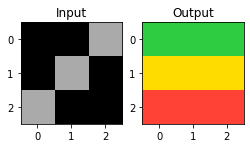

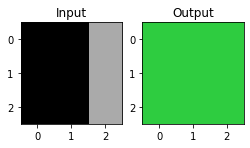

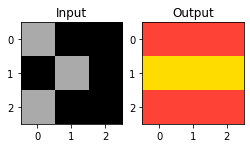

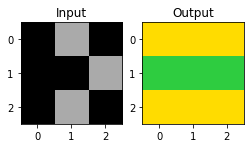

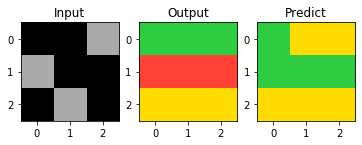

1it [00:01,  1.73s/it]


In [771]:
for task, prediction, solved in tqdm(zip(train_tasks, train_predictions, train_solved)):
    #if solved:
    for i in range(len(task['train'])):
        plot_sample(task['train'][i])

    for i in range(len(task['test'])):
        plot_sample(task['test'][i], prediction[i])

In [55]:
def replace_values(a, d):
    return np.array([d.get(i, -1) for i in range(a.min(), a.max() + 1)])[a - a.min()]


def get_outp(outp, dictionary=None, replace=True):
    if replace:
        outp = replace_values(outp, dictionary)

    outp_matrix_dims = outp.shape
    outp_probs_len = outp.shape[0]*outp.shape[1]*10
    outp = to_categorical(outp.flatten(),
                          num_classes=10).flatten()

    return outp, outp_probs_len, outp_matrix_dims

In [66]:
SIZE = 1000

In [123]:
x1 = train_tasks[0]["train"][0]["input"]
print(duplicate_matrix(x1,N=10))

[[0 0 5]
 [0 5 0]
 [5 0 0]
 [0 0 5]
 [0 5 0]
 [5 0 0]
 [0 0 5]
 [0 5 0]
 [5 0 0]
 [0 0 5]]


In [613]:
def flattener(pred):
    str_pred = str([row for row in pred])
    str_pred = str_pred.replace(', ', '')
    str_pred = str_pred.replace('[[', '|')
    str_pred = str_pred.replace('][', '|')
    str_pred = str_pred.replace(']]', '|')
    return str_pred

def make_prediction(tasks):
    ts = TaskSolver()
    result = pd.Series()
    for idx, task in tqdm(test_tasks.iteritems()):
        if input_output_shape_is_same(task):
            ts.train(task['train'])
            pred = ts.predict(task['test'])
        else:
            pred = [el['input'] for el in task['test']]
        
        for i, p in enumerate(pred):
            result[f'{idx}_{i}'] = flattener(np.array(p).tolist())
       
    return result

In [614]:
submission = make_prediction(test_tasks)
submission.head()

100it [00:19,  5.16it/s]


14754a24_0    |0050052050502545005|0550542250520450550|52505...
2037f2c7_0    |0000000000000000000000000|0000000000000000000...
00dbd492_0    |00000000000222220000|02222222228008020000|020...
19bb5feb_0    |000000000000000|000000000000000|0000000000000...
292dd178_0    |201011121111210|910111101111200|9121122912212...
dtype: object

In [615]:
submission = submission.reset_index()
submission.columns = ['output_id', 'output']
submission.to_csv('submission.csv', index=False)
submission

,output_id,output
0,14754a24_0,|0050052050502545005|0550542250520450550|52505...
1,2037f2c7_0,|0000000000000000000000000|0000000000000000000...
2,00dbd492_0,|00000000000222220000|02222222228008020000|020...
3,19bb5feb_0,|000000000000000|000000000000000|0000000000000...
4,292dd178_0,|201011121111210|910111101111200|9121122912212...
...,...,...
99,1c0d0a4b_0,|0000000000000|0020002000020|0020220020000|020...
100,00576224_0,|32|78|
101,2f0c5170_0,|8888888888888888888|8888888888888888888|88888...
102,33b52de3_0,|00000000000000000000000|000800088808880888088...
